In [1]:
import sys
import os

sys.path.append('/dfs/scratch0/vschen/metal')
os.environ['METALHOME'] = '/dfs/scratch0/vschen/metal'

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from metal.contrib.slicing.metrics import calc_slice_acc, calc_heads_acc

RUN_NAME = "test"

In [13]:
from metal.contrib.slicing.online_dp import MLPModule

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
train_kwargs = {
    "n_epochs": 3,
    "lr": 0.001,
    "l2": 0.0,
    "log_unit": "epochs",
#     "log_train_metrics_func": None,
#     "log_train_metrics": ["loss"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": [calc_slice_acc],
    "log_valid_metrics": ["accuracy"],
    "checkpoint": True,
    "checkpoint_metric": "accuracy",
    "writer": "tensorboard",
    "log_dir": f"{os.environ['METALHOME']}/tensorboard/",
    "run_name": RUN_NAME,
}

end_model_init_kwargs = {
    "layer_out_dims": [2, 10, 10, 2],
}

### FULL CONFIGS
dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "train_kwargs": train_kwargs,
    "slice_kwargs": {"vanilla": True},
}

uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "train_kwargs": train_kwargs
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5,
    "train_kwargs": train_kwargs
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5,
    "train_kwargs": train_kwargs
}

print("WARNING: Pay attention to slice weight!")

sm_dp_config = {
    'slice_kwargs': {
        'r': 5,
        'slice_weight': 0.1,
        'reweight': True
    },
    'train_kwargs': train_kwargs,
    'input_module_class': MLPModule,
    'input_module_init_kwargs': {
        'input_dim': 2,
        'output_dim': 5,
        'middle_dims': [5],
        'bias': True
    }
}

sm_hat_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 0.1,
        "reweight": True,
    },
    "train_kwargs": train_kwargs
}

sm_on_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_head_weight": 0.1,
        "Y_head_weight": 0.1 
    },
    "train_kwargs": train_kwargs
}

sm_mr_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "L_weight": 0.1,
        "Y_off_weight": 0.1,
        "online_head": True,
        "indicator": False,
        "mask_abstains": False,
        "verbose": True,
    },
    "train_kwargs": train_kwargs
}


Salt: 217015
[Trial 0]


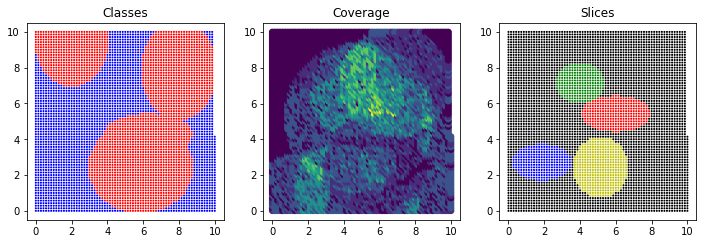

---------- Training SM_MR ----------
Added pepper=0.0 random negatives on 0/10 LFs

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Default to SliceMaster
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=10, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=10, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=10, out_features=1, bias=True)
)

In [18]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    train_slice_dp,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model


model_configs = {
#     "UNI": uni_config,
#     "UP": up_config,
#     "MoE": moe_config,
#     "DP": dp_config,
#     'SM_DP': sm_dp_config,
#     "SM_HAT": sm_hat_config,
#     "SM_ON": sm_on_config,
    "SM_MR": sm_mr_config,
}

NUM_TRIALS = 1
NUM_SLICES = 4
K = 2
M = 10
N = 5000
unipolar = False
pepper = 0.0
# A base to add to trial number to set a unique seed for each trial
salt = np.random.randint(1e6)
# salt = 42

print(f"Salt: {salt}")
if pepper:
    print(f"Pepper: {pepper}")

history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")

    L_kwargs = {'max_r': 7} if unipolar else {'max_r': 5} 
    L_kwargs["min_acc"] = 0.7
    Z_kwargs = {'num_slices': NUM_SLICES}
    L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                     L_kwargs=L_kwargs,
                                                     Z_kwargs=Z_kwargs,
                                                     unipolar=unipolar,
                                                     slice_source="conflicts",
                                                     seed=(salt + trial),
                                                     plotting=True)

    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
    L_train_raw = Ls[0].copy() # TEMP
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
        
        # Generate weak labels:
        if model_name == "UNI":
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train
        
        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)        
        
        # Train end model
        if model_name == "UNI":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == 'UP':
            # generates weighted Y_train and overwrites overwrites Ys[0] internally
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM_HAT":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="hat")
        elif model_name == "SM_ON":
            model = train_model(model_config, Ls, Xs, Ys, Zs, model_key="online")
        elif model_name == 'SM_DP':
            model = train_slice_dp(model_config, Ls, Xs, Ys, Zs)   
        elif model_name == 'SM_MR':
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")
            
        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)        
        
        # Save results
        history[model_name].append(results)

In [21]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

Average (n=1):


,SM_MR
all,0.630400
slice_1,0.773333
slice_2,0.426230
slice_3,0.857143
slice_4,1.000000
slice_avg,0.764176


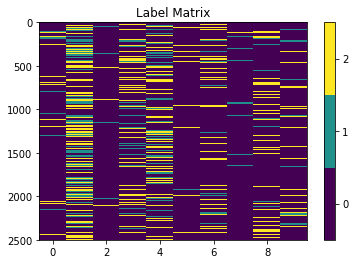

In [7]:
from metal.contrib.visualization.analysis import view_label_matrix
view_label_matrix(Ls[0])